# Seq2Vec Sentiment Modeling in Tensorflow

## 1.0 - Import Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import pandas as pd
from sklearn.metrics import mean_absolute_error
from keras import backend as K
from keras.layers import Dropout
import os
import numpy as np

In [2]:
CUR_DIR = os.path.abspath(os.curdir)
ROOT_DIR = os.path.dirname(CUR_DIR)
IMAGES_DIR = os.path.join(ROOT_DIR, "images")
DATA_DIR = os.path.join(ROOT_DIR, "data")
MODELS_DIR = os.path.join(ROOT_DIR, "models")
EVAL_DIR = os.path.join(ROOT_DIR, "evaluation")
MODEL_PERF_DIR = os.path.join(EVAL_DIR, "model_performance")
GRAPHS_DIR = os.path.join(EVAL_DIR, "graphs")
writepath = os.path.join(MODEL_PERF_DIR, "performance.csv")

## 1.1 Define Functions

In [3]:
plt.style.use('ggplot')

In [4]:
def plot_loss(history,model):
    """
    The purpose of this function is to plot the validation and training loss function across epochs.
    """
    plt.plot(history.history['mae'], label='training')
    plt.plot(history.history['val_mae'], label='val')
    plt.xlabel('epoch')
    plt.ylabel('mae')
    plt.title(f'Loss for {model.name}')
    plt.legend(loc='upper right')
    output_path = os.path.join(GRAPHS_DIR,f'Loss Plot {model.name}.png')
    plt.savefig(output_path)
    plt.show()
    print(output_path)

In [5]:
def relu_advanced(x):
    """The purpose of this function is the bound the output value of the network between 1 and 5 inclusively which matches the domain the stars get on the reviews."""
    return (K.relu(x, max_value=5))

In [6]:
def transpose_df(df,reset_index,prefix):
    if reset_index == False:
        out_df = df.groupby('star',as_index=False)['prediction'].mean().T
    elif reset_index == True:
        out_df = pd.DataFrame(df.groupby('star')['prediction'].skew()).reset_index().T
    new_header = out_df.iloc[0]
    new_header = [f'{prefix}_{int(i)}_Star' for i in new_header]
    new_header
    out_df = out_df[1:] #take the data less the header row
    out_df.columns = new_header
    return out_df

In [7]:
def write_performance(model,mae,writepath,eval_df):
    # df = pd.DataFrame(eval_df.groupby('star')['prediction'].skew()).reset_index().T#.pivot(columns='star',values='prediction')
    # new_header = df.iloc[0] #grab the first row for the header
    # new_header = [f'Prediction Skewness for {int(i)} Star' for i in new_header]
    # df = df[1:] #take the data less the header row
    # df.columns = new_header 
    data = {
        'model_name':model.name,
        'mae':mae
    }
    grouped_eval_df = eval_df.groupby('star',as_index=False)['prediction'].mean()
    avg_prefix = 'Average_Prediction_for'
    skew_prefix = 'Prediction_Skewness_for'
    avg_df = transpose_df(eval_df,False,avg_prefix)
    skew_df = transpose_df(eval_df,True,skew_prefix)
    
    # grouped_eval_df.to_csv(os.path.join(DATA_DIR,'output','summary', f'{model.name}'))
    for col in avg_df.columns:
        data.update({col:avg_df[col][0]})
    for col in skew_df.columns:
        data.update({col:skew_df[col][0]})
    print(data)
    out_df = pd.DataFrame(data,index=[0])
    mode = 'a' if os.path.exists(writepath) else 'w'
    header = False if os.path.exists(writepath) else True
    out_df.to_csv(writepath, mode=mode, index=False, header=header)
    # print message
    print("Data appended successfully.")

In [8]:
# df = pd.DataFrame(eval_df.groupby('star')['prediction'].skew()).reset_index().T#.pivot(columns='star',values='prediction')
# new_header = df.iloc[0] #grab the first row for the header
# new_header = [f'skewness for {int(i)} star' for i in new_header]
# df = df[1:] #take the data less the header row
# df.columns = new_header
# # df.index=1
# # df3=pd.DataFrame({'nice':1, 'yes':2})
# # df3.index=1
# # pd.concat([df,df3],axis=1,ignore_index=True)
# df#['skewness for 1 star'][0]

In [9]:
def plot_score_distribution_by_group(model,eval_df):
    # Create subplots 
    fig, axes = plt.subplots(nrows=2, ncols=3, 
                           constrained_layout = True,figsize=(15,10))
    fig.delaxes(axes[1][2])
    plt.text(x=0.5, y=0.94, s=f"Model Prediction Distribution by Stars for model: {model.name}", fontsize=18, ha="center", transform=fig.transFigure)
    plt.subplots_adjust(top=0.9, wspace=0.3)

    # Generate histograms
    i=0
    colors = ['black', 'midnightblue', 'darkgreen','mediumpurple','darkred']
    for ax, (name, subdf) in zip(axes.flatten(), eval_df.groupby('star')):
        subdf.hist('prediction', ax=ax, rwidth=0.9,color = colors[i])
        i+=1
        ax.set_title(name)
        ax.set_xlabel('prediction')
        ax.set_ylabel('count')
    # plt.subplots_adjust(wspace=1, hspace=1)
    plt.savefig(os.path.join(GRAPHS_DIR,f'Prediction_Distribution_{model.name}.png'))
    plt.show()

In [10]:
def performance_evaluation(X_test, y_test, model):
    y_pred = model.predict(X_test)
    print(f'The prediction values range between {min(y_pred)} and {max(y_pred)}')
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error: {mae}')
    eval_df = pd.merge(X_test, y_test, left_index=True, right_index=True)
    eval_df['prediction'] = y_pred.ravel()
    eval_df['absolute_error'] = (eval_df['prediction'] - eval_df['star']).abs()
    eval_df.to_csv(os.path.join(DATA_DIR,'output','scoring', f'{model.name}'))
    # grouped_eval_df = eval_df.groupby('star',as_index=False)['prediction'].mean()
    # grouped_eval_df.to_csv(os.path.join(DATA_DIR,'output','summary', f'{model.name}'))
    plot_score_distribution_by_group(model,eval_df)
    write_performance(model,mae,writepath,eval_df)
    print('Done')

## 1.1 Import Data 

In [11]:
validation_df = pd.read_csv(os.path.join(DATA_DIR,'raw','validation.csv'))
training_df = pd.read_csv(os.path.join(DATA_DIR,'raw','training.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR,'raw','test.csv'))

X_train = training_df['review']
y_train = training_df['star']

X_val = validation_df['review']
y_val = validation_df['star']

X_test = test_df['review']
y_test = test_df['star']

# Convert to tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(buffer_size=1024).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test)).shuffle(buffer_size=1024).batch(128)
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(buffer_size=1024).batch(128)

2022-03-14 08:19:46.545978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-14 08:19:46.546043: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-14 08:19:46.546065: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (42b10f96906e): /proc/driver/nvidia/version does not exist
2022-03-14 08:19:46.546331: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.0 Create embedding layer & Build simple model

In [12]:
handle = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1'
# emb_layer = hub.KerasLayer(handle = handle,
#                input_shape=[],dtype=tf.string,trainable=True)

emb_layer = hub.KerasLayer(handle = handle, output_shape=(20,1),
               input_shape=(None,),dtype=tf.string,trainable=True, name='embed')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

2022-03-14 08:19:46.685308: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [13]:
embed = hub.load(handle)
embeddings = embed(["hello","hello"])
embeddings

<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[ 0.52211034, -0.5292976 ,  0.33719632,  0.0902942 , -0.6266122 ,
         0.45860922, -0.70826894,  0.55458295,  1.1077714 ,  0.40197402,
        -1.5735748 ,  0.35205668,  0.8920213 , -0.05832118, -0.29793447,
        -0.2865127 ,  0.7564523 ,  0.6519507 , -0.7274325 , -0.45961407],
       [ 0.52211034, -0.5292976 ,  0.33719632,  0.0902942 , -0.6266122 ,
         0.45860922, -0.70826894,  0.55458295,  1.1077714 ,  0.40197402,
        -1.5735748 ,  0.35205668,  0.8920213 , -0.05832118, -0.29793447,
        -0.2865127 ,  0.7564523 ,  0.6519507 , -0.7274325 , -0.45961407]],
      dtype=float32)>

## Baseline

In [14]:
# emb_layer = hub.KerasLayer(handle = handle, output_shape=(20,1),
#                input_shape=(None,),dtype=tf.string,trainable=True, name='embed')

# base_model = keras.Sequential([
#         layers.Input(shape=(), name="Input", dtype=tf.string),
#         emb_layer,
#         layers.Dense(10,activation='relu'),
#         layers.Dropout(0.1),
#         layers.Dense(1,activation='relu')])

# base_model.compile(loss=tf.keras.losses.MeanSquaredError(),
#                    optimizer=keras.optimizers.Adam(lr=0.00005,decay=1e-6),
#                    metrics=['mse','mae'])

# base_model.summary()
# tf.keras.utils.plot_model(base_model,show_shapes=True, show_dtype=True,
#     show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [15]:
epochs = 100

base_model = keras.Sequential([
        layers.Input(shape=(), name="Input", dtype=tf.string),
        emb_layer,
        layers.Dense(10,activation='relu', dtype=tf.float32),
        layers.Dense(1,activation=relu_advanced)],name='2.0-Baseline-No-Regularization')

base_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=keras.optimizers.Adam(lr=0.0003,decay=1e-6),
                   metrics=['mse','mae'])


base_history = base_model.fit(train_ds,
                    epochs = epochs,
                    validation_data=val_ds,
                    callbacks=[callback],
                    verbose=1)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
1351/1351 [==============================] - 11s 7ms/step - loss: 4.7300 - mse: 4.7300 - mae: 1.6326 - val_loss: 2.2511 - val_mse: 2.2511 - val_mae: 1.0280
Epoch 2/100
1351/1351 [==============================] - 9s 7ms/step - loss: 1.9078 - mse: 1.9078 - mae: 0.9256 - val_loss: 1.6965 - val_mse: 1.6965 - val_mae: 0.8714
Epoch 3/100
1351/1351 [==============================] - 9s 7ms/step - loss: 1.5857 - mse: 1.5857 - mae: 0.8363 - val_loss: 1.5205 - val_mse: 1.5205 - val_mae: 0.8263
Epoch 4/100
1351/1351 [==============================] - 9s 6ms/step - loss: 1.4480 - mse: 1.4480 - mae: 0.8001 - val_loss: 1.4298 - val_mse: 1.4298 - val_mae: 0.7995
Epoch 5/100
1351/1351 [==============================] - 9s 6ms/step - loss: 1.3648 - mse: 1.3648 - mae: 0.7759 - val_loss: 1.3726 - val_mse: 1.3726 - val_mae: 0.7806
Epoch 6/100
1351/1351 [==============================] - 9s 6ms/step - loss: 1.3076 - mse: 1.3076 - mae: 0.7579 - val_loss: 1.3349 - val_mse: 1.3349 - val_mae: 0.77

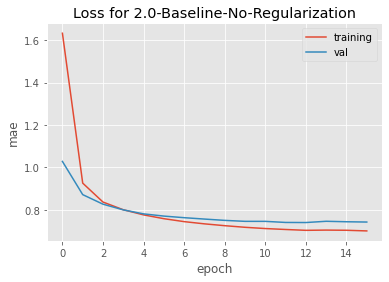

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.0-Baseline-No-Regularization.png


In [16]:
plot_loss(base_history,base_model)

The prediction values range between [0.] and [5.]
Mean Absolute Error: 0.7429187666448455


/tmp/ipykernel_10340/1284328143.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(top=0.9, wspace=0.3)


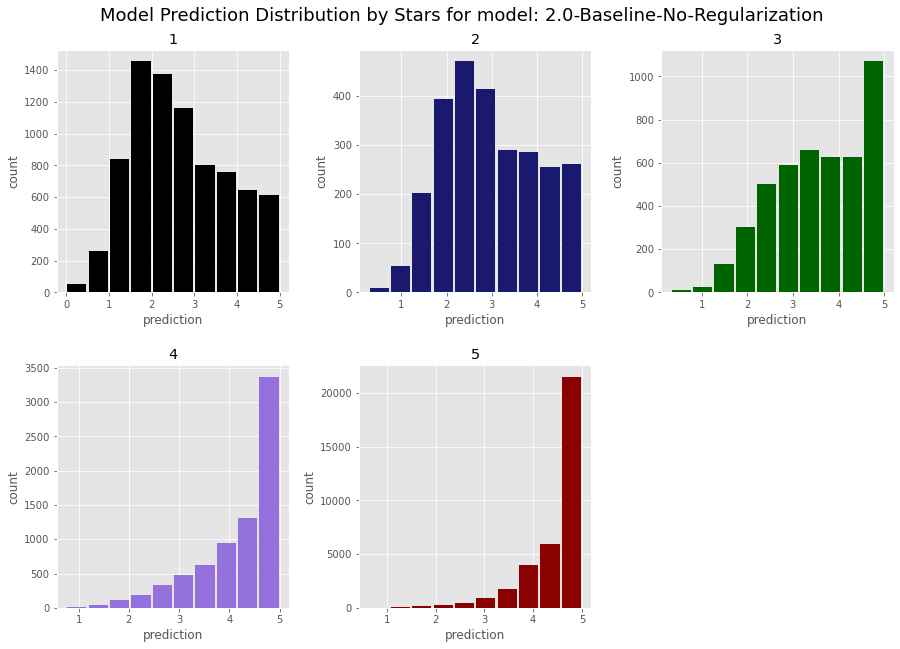

{'model_name': '2.0-Baseline-No-Regularization', 'mae': 0.7429187666448455, 'Average_Prediction_for_1_Star': 2.6722655296325684, 'Average_Prediction_for_2_Star': 2.973604679107666, 'Average_Prediction_for_3_Star': 3.5756986141204834, 'Average_Prediction_for_4_Star': 4.226134777069092, 'Average_Prediction_for_5_Star': 4.534423828125, 'Prediction_Skewness_for_1_Star': 0.35366055369377136, 'Prediction_Skewness_for_2_Star': 0.23295365273952484, 'Prediction_Skewness_for_3_Star': -0.3094787001609802, 'Prediction_Skewness_for_4_Star': -1.1502763032913208, 'Prediction_Skewness_for_5_Star': -1.7655754089355469}
Data appended successfully.
Done


In [17]:
performance_evaluation(X_test, y_test, base_model)

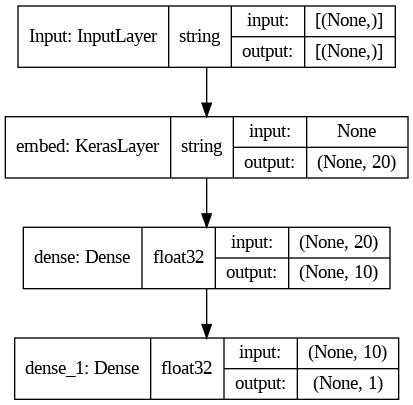

In [18]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{base_model.name}.png')
tf.keras.utils.plot_model(base_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [19]:
# plot_performance(base_history,2.0,'No-Regularization','Baseline')

In [20]:
# plt.plot(base_history.history['mae'], label='training')
# plt.plot(base_history.history['val_mae'], label='val')
# plt.xlabel('epoch')
# plt.ylabel('mae')
# plt.title('Baseline No Regularization')
# plt.legend(loc='upper right')
# plt.savefig(os.path.join(IMAGES_DIR,'2.0_No-Regularizer-Baseline.png'))
# plt.show()

In [21]:
# y_pred_base = base_model.predict(X_test)
# y_pred_base.ravel()

In [22]:
# print(min(y_pred_base),max(y_pred_base))

In [23]:
# mean_absolute_error(y_test, y_pred_base)

In [24]:
base_model.save(os.path.join(MODELS_DIR,base_model.name))

2022-03-14 08:22:33.231805: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-Baseline-No-Regularization/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-Baseline-No-Regularization/assets


In [25]:
# new_model = tf.keras.models.load_model(os.path.join(MODELS_DIR,'2.1-LSTM_TFIDF'))
# new_model.summary()

In [26]:
# eval_df = pd.merge(X_test, y_test, left_index=True, right_index=True)
# eval_df['prediction'] = base_model.predict(eval_df.review).ravel()
# eval_df['absolute_error'] = (eval_df['prediction'] - eval_df['star']).abs()
# eval_df

In [27]:
# eval_df.groupby('star',as_index=False)['prediction'].mean()

## RNN

In [28]:
embed
embed(X_train).shape

TensorShape([172839, 20])

In [29]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)
rnn_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    # layers.Dense(20,activation='relu'),
    # layers.SimpleRNN(20,return_sequences=True,input_shape=(None, 20), activation='relu'),
    # layers.SimpleRNN(15,input_shape=(None, 20), activation='tanh',return_sequences=True),
    layers.SimpleRNN(2, activation='tanh',return_sequences=False),
    # layers.SimpleRNN(10,input_shape=(None, 15), activation='tanh',return_sequences=False),

    # layers.Dense(15,activation='tanh'),
    layers.Dense(1,activation=relu_advanced)
],name='2.0-RNN-No-Regularization')

rnn_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mse','mae'])

num_epochs=100
rnn_history=rnn_model.fit(train_ds, 
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
1351/1351 [==============================] - 18s 12ms/step - loss: 5.5202 - mse: 5.5202 - mae: 2.0550 - val_loss: 2.1746 - val_mse: 2.1746 - val_mae: 1.3061
Epoch 2/100
1351/1351 [==============================] - 15s 11ms/step - loss: 1.8280 - mse: 1.8280 - mae: 1.1277 - val_loss: 1.4851 - val_mse: 1.4851 - val_mae: 0.9604
Epoch 3/100
1351/1351 [==============================] - 15s 11ms/step - loss: 1.3773 - mse: 1.3773 - mae: 0.8980 - val_loss: 1.3415 - val_mse: 1.3415 - val_mae: 0.8686
Epoch 4/100
1351/1351 [==============================] - 15s 11ms/step - loss: 1.2779 - mse: 1.2779 - mae: 0.8424 - val_loss: 1.2892 - val_mse: 1.2892 - val_mae: 0.8405
Epoch 5/100
1351/1351 [==============================] - 15s 11ms/step - loss: 1.2285 - mse: 1.2285 - mae: 0.8172 - val_loss: 1.2616 - val_mse: 1.2616 - val_mae: 0.8242
Epoch 6/100
1351/1351 [==============================] - 15s 11ms/step - loss: 1.1962 - mse: 1.1962 - mae: 0.8008 - val_loss: 1.2450 - val_mse: 1.2450 - va

In [30]:
rnn_model.summary()

Model: "2.0-RNN-No-Regularization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (KerasLayer)           (None, 20)                389380    
_________________________________________________________________
reshape (Reshape)            (None, 20, 1)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 2)                 8         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 389,391
Trainable params: 389,391
Non-trainable params: 0
_________________________________________________________________


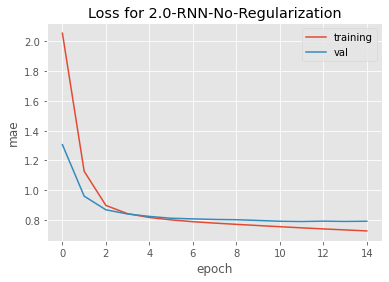

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.0-RNN-No-Regularization.png


In [31]:
plot_loss(rnn_history,rnn_model)

The prediction values range between [0.] and [4.839706]
Mean Absolute Error: 0.7907937264296776


/tmp/ipykernel_10340/1284328143.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(top=0.9, wspace=0.3)


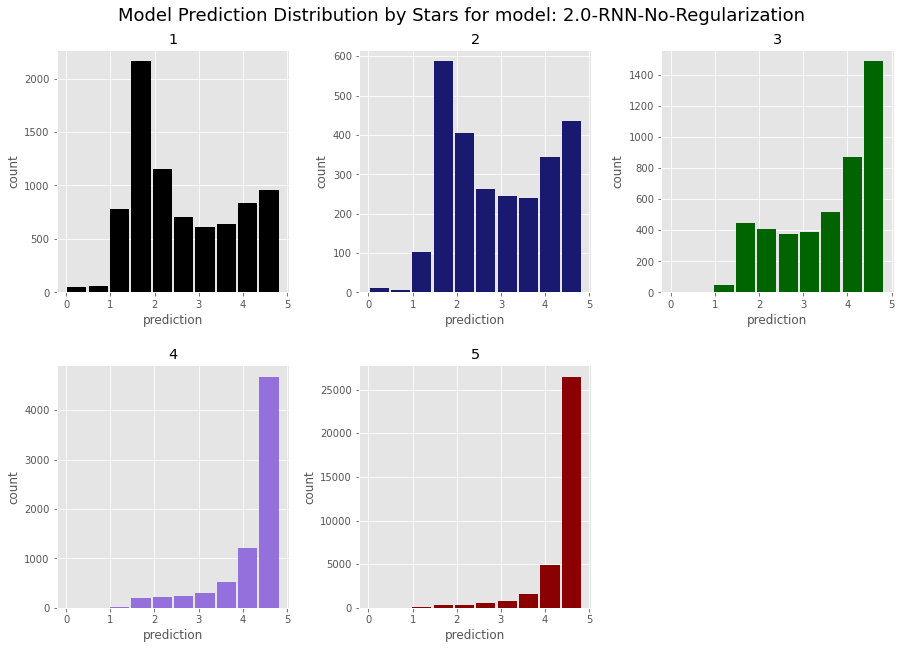

{'model_name': '2.0-RNN-No-Regularization', 'mae': 0.7907937264296776, 'Average_Prediction_for_1_Star': 2.653959274291992, 'Average_Prediction_for_2_Star': 2.9463815689086914, 'Average_Prediction_for_3_Star': 3.5810296535491943, 'Average_Prediction_for_4_Star': 4.205197811126709, 'Average_Prediction_for_5_Star': 4.449437141418457, 'Prediction_Skewness_for_1_Star': 0.4042260944843292, 'Prediction_Skewness_for_2_Star': 0.13779953122138977, 'Prediction_Skewness_for_3_Star': -0.6325323581695557, 'Prediction_Skewness_for_4_Star': -1.8772002458572388, 'Prediction_Skewness_for_5_Star': -2.843937873840332}
Data appended successfully.
Done


In [32]:
performance_evaluation(X_test, y_test, rnn_model)

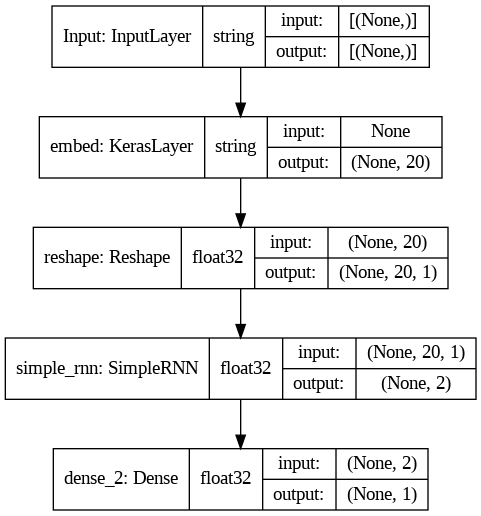

In [33]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{rnn_model.name}.png')
tf.keras.utils.plot_model(rnn_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [34]:
# y_pred_rnn = rnn_model.predict(test_ds)
# y_pred_rnn

In [35]:
rnn_model.save(os.path.join(MODELS_DIR,rnn_model.name))
# mean_absolute_error(y_test, y_pred_rnn)

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-RNN-No-Regularization/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-RNN-No-Regularization/assets


In [36]:
# max(y_pred)

In [37]:
# min(y_pred)

In [38]:
# rnn_eval_df = pd.merge(X_test, y_test, left_index=True, right_index=True)
# rnn_eval_df['prediction'] = rnn_model.predict(rnn_eval_df.review).ravel()
# rnn_eval_df['absolute_error'] = (rnn_eval_df['prediction'] - rnn_eval_df['star']).abs()
# rnn_eval_df

In [39]:
# max(rnn_eval_df.star)

In [40]:
# rnn_eval_df.groupby('star',as_index=False)['prediction'].mean()

## GRU

In [41]:
# gru_emb_layer = emb_layer = hub.KerasLayer(handle = handle, output_shape=[20],
#                input_shape=(),dtype=tf.string,trainable=True)
gru_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    # layers.Dense(20,activation='relu'),
    # layers.SimpleRNN(20,return_sequences=True,input_shape=(None, 20), activation='relu'),
    # layers.GRU(15,input_shape=(None, 20), activation='tanh',return_sequences=True),
    # layers.GRU(10,input_shape=(None, 15), activation='tanh',return_sequences=False),
    layers.GRU(10, activation='tanh',return_sequences=False),
    layers.Dense(5,activation='tanh'),
    layers.Dense(1,activation=relu_advanced)
],name='2.0-GRU-No-Regularization')
gru_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mse','mae'])

num_epochs=100
gru_history=gru_model.fit(train_ds,
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
1351/1351 [==============================] - 28s 20ms/step - loss: 2.4098 - mse: 2.4098 - mae: 1.1952 - val_loss: 1.2335 - val_mse: 1.2335 - val_mae: 0.8062
Epoch 2/100
1351/1351 [==============================] - 25s 18ms/step - loss: 1.1229 - mse: 1.1229 - mae: 0.7614 - val_loss: 1.2122 - val_mse: 1.2122 - val_mae: 0.7861
Epoch 3/100
1351/1351 [==============================] - 24s 18ms/step - loss: 1.0881 - mse: 1.0881 - mae: 0.7454 - val_loss: 1.2089 - val_mse: 1.2089 - val_mae: 0.7779
Epoch 4/100
1351/1351 [==============================] - 22s 17ms/step - loss: 1.0639 - mse: 1.0639 - mae: 0.7348 - val_loss: 1.2108 - val_mse: 1.2108 - val_mae: 0.7714
Epoch 5/100
1351/1351 [==============================] - 22s 17ms/step - loss: 1.0432 - mse: 1.0432 - mae: 0.7249 - val_loss: 1.2130 - val_mse: 1.2130 - val_mae: 0.7717
Epoch 6/100
1351/1351 [==============================] - 23s 17ms/step - loss: 1.0244 - mse: 1.0244 - mae: 0.7154 - val_loss: 1.2225 - val_mse: 1.2225 - va

In [42]:
gru_model.save(os.path.join(MODELS_DIR,gru_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-GRU-No-Regularization/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-GRU-No-Regularization/assets


In [43]:
# y_pred_gru = gru_model.predict(test_ds)
# y_pred_gru

In [44]:
# gru_eval_df = pd.merge(X_test, y_test, left_index=True, right_index=True)
# gru_eval_df['prediction'] = gru_model.predict(gru_eval_df.review).ravel()
# gru_eval_df['absolute_error'] = (gru_eval_df['prediction'] - gru_eval_df['star']).abs()
# gru_eval_df

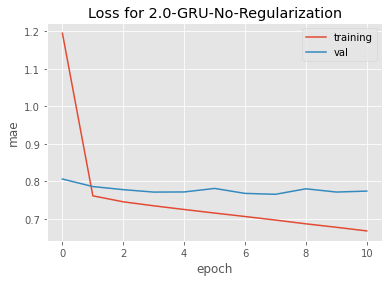

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.0-GRU-No-Regularization.png


In [45]:
plot_loss(gru_history,gru_model)

The prediction values range between [0.16858098] and [4.884815]
Mean Absolute Error: 0.7706682471585253


/tmp/ipykernel_10340/1284328143.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(top=0.9, wspace=0.3)


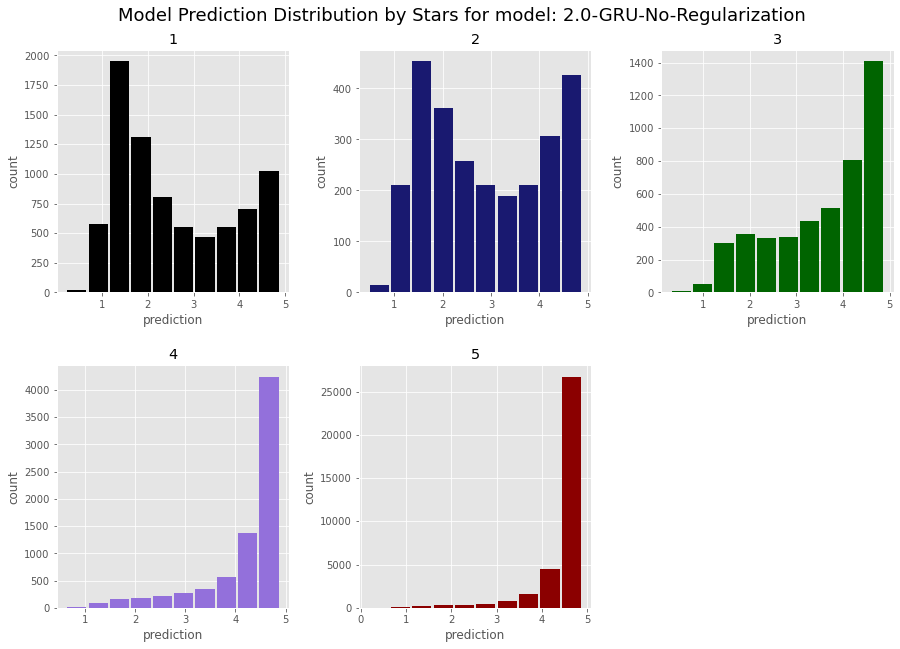

{'model_name': '2.0-GRU-No-Regularization', 'mae': 0.7706682471585253, 'Average_Prediction_for_1_Star': 2.5556933879852295, 'Average_Prediction_for_2_Star': 2.890089750289917, 'Average_Prediction_for_3_Star': 3.5589537620544434, 'Average_Prediction_for_4_Star': 4.193904399871826, 'Average_Prediction_for_5_Star': 4.467925071716309, 'Prediction_Skewness_for_1_Star': 0.48524999618530273, 'Prediction_Skewness_for_2_Star': 0.1429458111524582, 'Prediction_Skewness_for_3_Star': -0.6831501722335815, 'Prediction_Skewness_for_4_Star': -1.8783830404281616, 'Prediction_Skewness_for_5_Star': -2.993015766143799}
Data appended successfully.
Done


In [46]:
performance_evaluation(X_test, y_test, gru_model)

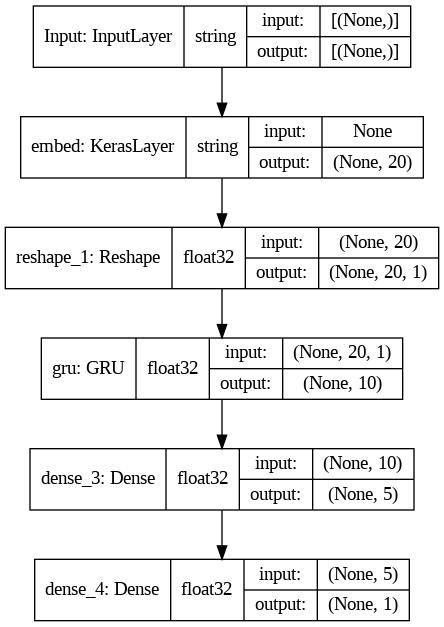

In [47]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{gru_model.name}.png')
tf.keras.utils.plot_model(gru_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [48]:
# gru_eval_df.groupby('star',as_index=False)['prediction'].mean()

## LSTM

In [49]:
# lstm_emb_layer = hub.KerasLayer(handle = handle, output_shape=[20],
#                input_shape=(),dtype=tf.string,trainable=True)
lstm_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    # layers.Dense(20,activation='relu'),
    # layers.SimpleRNN(20,return_sequences=True,input_shape=(None, 20), activation='relu'),
    # layers.GRU(15,input_shape=(None, 20), activation='tanh',return_sequences=True),
    # layers.GRU(10,input_shape=(None, 15), activation='tanh',return_sequences=False),
    layers.LSTM(10, activation='tanh',return_sequences=False),
    layers.Dense(5,activation='tanh'),
    layers.Dense(1,activation=relu_advanced)
],name='2.0-LSTM-No-Regularization')
lstm_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mse','mae'])

num_epochs=100
lstm_history=lstm_model.fit(train_ds,
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
1351/1351 [==============================] - 24s 17ms/step - loss: 3.0496 - mse: 3.0496 - mae: 1.4432 - val_loss: 1.2559 - val_mse: 1.2559 - val_mae: 0.8543
Epoch 2/100
1351/1351 [==============================] - 22s 17ms/step - loss: 1.0765 - mse: 1.0765 - mae: 0.7509 - val_loss: 1.2083 - val_mse: 1.2083 - val_mae: 0.7761
Epoch 3/100
1351/1351 [==============================] - 23s 17ms/step - loss: 0.9920 - mse: 0.9920 - mae: 0.7008 - val_loss: 1.2257 - val_mse: 1.2257 - val_mae: 0.7714
Epoch 4/100
1351/1351 [==============================] - 22s 17ms/step - loss: 0.9507 - mse: 0.9507 - mae: 0.6787 - val_loss: 1.2369 - val_mse: 1.2369 - val_mae: 0.7652
Epoch 5/100
1351/1351 [==============================] - 23s 17ms/step - loss: 0.9223 - mse: 0.9223 - mae: 0.6646 - val_loss: 1.2491 - val_mse: 1.2491 - val_mae: 0.7678
Epoch 6/100
1351/1351 [==============================] - 23s 17ms/step - loss: 0.9008 - mse: 0.9008 - mae: 0.6535 - val_loss: 1.2558 - val_mse: 1.2558 - va

The prediction values range between [0.249928] and [4.903827]
Mean Absolute Error: 0.7744239736843367


/tmp/ipykernel_10340/1284328143.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(top=0.9, wspace=0.3)


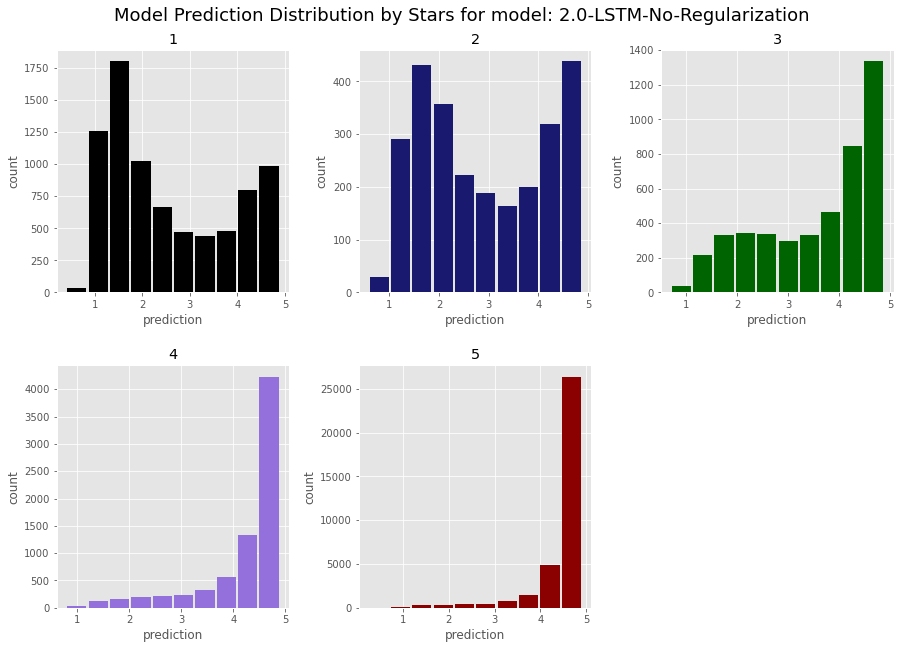

{'model_name': '2.0-LSTM-No-Regularization', 'mae': 0.7744239736843367, 'Average_Prediction_for_1_Star': 2.555025815963745, 'Average_Prediction_for_2_Star': 2.8945398330688477, 'Average_Prediction_for_3_Star': 3.5617637634277344, 'Average_Prediction_for_4_Star': 4.195704460144043, 'Average_Prediction_for_5_Star': 4.467461109161377, 'Prediction_Skewness_for_1_Star': 0.4759649336338043, 'Prediction_Skewness_for_2_Star': 0.1319805085659027, 'Prediction_Skewness_for_3_Star': -0.6831847429275513, 'Prediction_Skewness_for_4_Star': -1.9068827629089355, 'Prediction_Skewness_for_5_Star': -3.1012306213378906}
Data appended successfully.
Done


In [50]:
performance_evaluation(X_test, y_test, lstm_model)

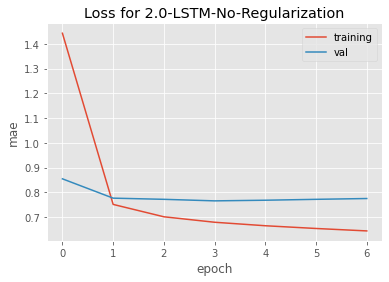

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.0-LSTM-No-Regularization.png


In [51]:
plot_loss(lstm_history,lstm_model)

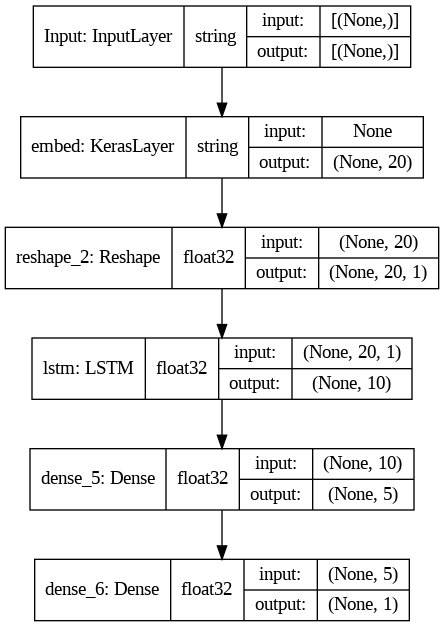

In [52]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{lstm_model.name}.png')
tf.keras.utils.plot_model(lstm_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [53]:
lstm_model.save(os.path.join(MODELS_DIR,lstm_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-LSTM-No-Regularization/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-LSTM-No-Regularization/assets


In [54]:
# plt.plot(lstm_history.history['mae'], label='training')
# plt.plot(lstm_history.history['val_mae'], label='val')
# plt.xlabel('epoch')
# plt.ylabel('mae')
# plt.title('LSTM No Regularization')
# plt.legend(loc='upper right')
# plt.savefig(os.path.join(IMAGES_DIR,'2.0_No-Regularizer-LSTM.png'))
# plt.show()

In [55]:
# lstm_eval_df = pd.merge(X_test, y_test, left_index=True, right_index=True)
# lstm_eval_df['prediction'] = lstm_model.predict(lstm_eval_df.review).ravel()
# lstm_eval_df['absolute_error'] = (lstm_eval_df['prediction'] - lstm_eval_df['star']).abs()
# lstm_eval_df

In [56]:
# lstm_eval_df.groupby('star',as_index=False)['prediction'].mean()